# Principal Component Analysis

- It is a statistical technique used to reduce the dimensionality of large datasets while retaining most of the information in the dataset. 
- PCA is used in various fields such as neuroscience, quantitative finance, image compression, facial recognition and many more.
- Here we will implement PCA by scratch and have a full view of the method.
- this blog is very good, I recommend reading it. <http://blog.codinglabs.org/articles/pca-tutorial.html>
## Steps of PCA
- Standardize the data
- Calculate the covariance matrix
- Calculate the eigenvector and eigenvalues of the covariance matrix
- Sort the eigenvalues in descending order and choose $k$ igenvectors that correspond to the $k$ largest eigenvalues to form a new matrix.
- Transform the original data into the new $k$ dimensional space.


In [13]:
import numpy as np
from numpy import ndarray

class PCA():
    def __init__(self,n_components:int):
        
        self.n_components = n_components
    
    def fit(self,X:ndarray,y:ndarray=None):
        
        # 1. norm data
        X_std = (X-np.mean(X,axis=0))/X.std(axis=0)
        
        # 2. get the cov mat
        cov_mat = np.cov(X_std.T)
        # also we can use this line
        # X_std.T@X_std/len(X_std)
        
        # 3. get the eigenvalues eigenvectors of the cov mat
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        
        # 4. sort the eigenvalues in decreasing order and select top-k eigenvectors according to the eigenvalues
        eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        matrix_w = np.hstack([(eig_pairs[i][1].reshape(len(eig_vals), 1)) for i in range(self.n_components)])
        
        # 5. store the matrix
        self.matrix_w = matrix_w
        self.X_std = X_std
        self.eig_pairs = eig_pairs
        
    def fit_transform(self,X:ndarray,y:ndarray=None):
        self.fit(X,y)
        return self.X_std.dot(self.matrix_w)

    def predict(self,X:ndarray,y:ndarray=None):
        X_std = (X-np.mean(X,axis=0))/np.std(X,axis=0)
        return X_std.dot(self.matrix_w)

Load the data and test the PCA model

In [14]:
from sklearn.datasets import load_iris
data = load_iris()

X = data.data
y = data.target

In [15]:
pca= PCA(2)
X_pca = pca.fit_transform(X)

Apply a linear model

In [16]:
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression(max_iter=500)

cls.fit(X,y)
cls.score(X,y)

0.9733333333333334

In [17]:
cls = LogisticRegression()

cls.fit(X_pca,y)
cls.score(X_pca,y)

0.9333333333333333

Visualize

In [25]:
eigen_values = [pca.eig_pairs[i][0] for i in range(len(pca.eig_pairs))]
eigen_values

[2.9380850501999936,
 0.920164904162487,
 0.14774182104494776,
 0.02085386217646217]

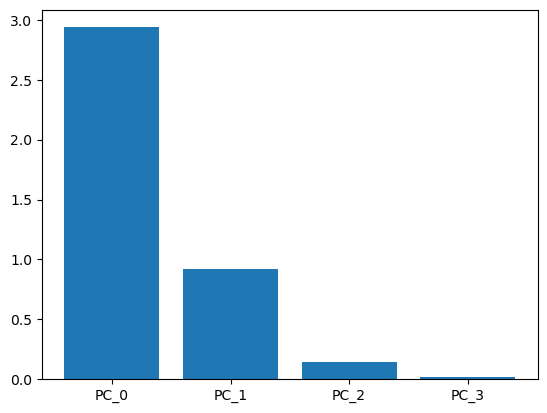

In [33]:
from matplotlib import pyplot as plt
plt.bar(["PC_{}".format(i) for i in range(len(eigen_values))],eigen_values)
plt.show()

We can find that at the sacrifice of a little accuracy, we can reduce the dimension of the data from 4 to 2.

# Mathmatical Knowledge Behind PCA

- Unsupervised
- Continuous
- Dimensionality Reduction

## Preliminary

- Mean
  $$
  \bar{x} = \frac{1}{n} \sum_{i=1}^N x_i
  $$

- Variance
  $$
  S^2 = \frac{1}{n-1} \sum_{i=1}^N (x_i-\bar{x})^2
  $$

- Covariance
  $$
  Cov(X,Y) = \mathbb{E}[(X-\mathbb{E}(X))(Y-\mathbb{E}(Y))]
  = \frac{1}{n-1} \sum_{i=1}^N (x_i-\bar{x})(y_i-\bar{y})
  $$

variance is the special case of covariance

## What does each step mean?

1. Norm the data

    ```python
    X_std = (X-np.mean(X,axis=0))/np.std(X,axis=0)
    ```

    Assume the data has $N$ samples and each sample has $d$ features.

    $$
    \mathbf{X} = [X_1,X_2,\dots,X_N]\\
    X_i = [f_{i1},f_{i2},\dots,f_{id}]
    $$

    We normalize the data using the following equations, it will be used in the next step!
    $$
    \tilde{X}_i =[\tilde{f}_{i1},\tilde{f}_{i2},\dots,\tilde{f}_{id}] \\
    \tilde{f}_{ij} = \frac{f_{ij} - \bar{f}_{ij}}{\sqrt{\frac{1}{N}\sum_{k=1}^N (f_{kj}-\bar{f}_{kj})^2}}\\
    \bar{f}_{ij} = f_{ij} - \frac{1}{N}\sum_{k=1}^N f_{kj}
    $$

    substract mean and divide by the standard deviation.

    The reason why we divide by the standard deviation is to ensure that all features are on a similar scale. This is important because PCA is sensitive to the scale of the features. By dividing by the standard deviation, we ensure that all features have a similar variance.

2. Covariance matrix
   
   ```python
   cov_mat = np.cov(X_std.T)
   # Also can be replaced with this line
   X_std.T@X_std/len(X_std)
   ```
   
   Recall   
  $$
  Cov(X,Y) = \mathbb{E}[(X-\mathbb{E}(X))(Y-\mathbb{E}(Y))]
  = \frac{1}{n-1} \sum_{i=1}^N (x_i-\bar{x})(y_i-\bar{y})
  $$

  So we have $Cov(f_{d_1},f_{d_2}) = \frac{1}{N} \sum_{i=1}^N f_{id_1}f_{id_2}$ because the mean is 0.
  
  Here, why do we use `X_std.T@X_std/len(X_std)`

  Recall the matrix $X$ with shape $N\times d$
  $$
  \left[
  \begin{matrix}
  f_{11}&f_{12}&\dots &f_{1d}\\
  &\vdots&\\
  f_{N1}&f_{N2}&\dots &f_{Nd}\\
  \end{matrix}
  \right]
  $$

  $X^T$ is this, with shape $d \times N$:
  $$
  \left[
  \begin{matrix}
  f_{11}&f_{21}&\dots &f_{N1}\\
  &\vdots&\\
  f_{1d}&f_{2d}&\dots &f_{Nd}\\
  \end{matrix}
  \right]
  $$

  So, $\frac{1}{N}X^TX$ equals:
  $$
  \left[
  \begin{matrix}
  \frac{1}{N}\sum_{k=1}^N f_{k1}f_{k1} & \frac{1}{N}\sum_{k=1}^N f_{k1}f_{k2} & \dots & \frac{1}{N}\sum_{k=1}^N f_{k1}f_{kd}\\
  \frac{1}{N}\sum_{k=1}^N f_{k2}f_{k1} & \frac{1}{N}\sum_{k=1}^N f_{k2}f_{k2} & \dots & \frac{1}{N}\sum_{k=1}^N f_{k2}f_{kd}\\
  \vdots&\\
  \frac{1}{N}\sum_{k=1}^N f_{kd}f_{k1} & \frac{1}{N}\sum_{k=1}^N f_{kd}f_{k2} & \dots & \frac{1}{N}\sum_{k=1}^N f_{kd}f_{kd}\\
  \end{matrix}
  \right]
  $$

  See what? the entry of the i-th row and j-th col is the covariance of feature i and feature j, that is why we need to normalize the data in the first step. And this matrix is symmetric.

3. get the eigenvalues eigenvectors of the cov mat
   
   `We wish to find the direction that can maximize the variance, and the covariance of every pair of features is zero.`

   So we need to diagonalize the covariance matrix, assume $P$ is the transformation matrix and assume $C = \frac{1}{N}X^TX$

   the covariance of $PX$ is:
   $$
   \begin{aligned}
   Cov(PX) &= \frac{1}{N} PX(PX)^T \\
   &=\frac{1}{N} PXX^TP^T\\
   &=P\frac{1}{N} XX^TP^T\\
   &=P(\frac{1}{N} XX^T)P^T\\
   \end{aligned}
   $$
  
   
   $C$ is symmetric, we can find $N$ orthogonal eigenvectors $E=[e_1,\dots,e_N]$, and we have
   $$
   E^TCE = \Lambda = \left(
    \begin{matrix}
    \lambda_1 &&&\\
    &\lambda_2&&\\
    &&\ddots&\\
    &&&\lambda_N\\
    \end{matrix}
   \right)
   $$

  where $\Lambda$ is diagonal matrix, and $\lambda_i$ is the eigenvectors.

4. sort the eigenvalues in decreasing order and select top-k eigenvectors according to the eigenvalues
   Here we just sort the eigenvectors and find top-k features with largest variance.
   And we have already found the transformation matrix $P$ , $P= E^T$ 